In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import pickle
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

In [5]:
areas_of_interest = {
    'MO': ['MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b', 'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'],
    'SM-TH': ['AV', 'CL', 'MD', 'PO', 'PF', 'VAL', 'VPL', 'VPM', 'VM'],
    'RT-TH': ['RT'],
}
areacolors = {'MO': 'blueviolet', 'SM-TH': 'limegreen', 'RT-TH': 'salmon'}

#### Functions

In [6]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

#### Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [8]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\psilocybin_exp'

### Load subjects

In [9]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})

In [10]:
subject_df[28:]

,exp_type,mouse,experiment,sweep_states,stim_depth,bad_chs,analyze,data_loc,CCF_res,notes
28,isoflurane,569070,estim1_2021-04-01_10-27-33,"awake,isoflurane,isoflurane,recovery","deep,deep,ignore,ignore","2,3,4,13",False,F:\ZZmanuscript_eLife\mouse569070\estim1_2021-...,10,"anterior MOs with 2 depths, no brain area assi..."
29,isoflurane,569073,estim_vis_2021-04-15_10-27-22,"awake,isoflurane,isoflurane,recovery,recovery",deep,"3,4,13",True,F:\ZZmanuscript_eLife\mouse569073\estim_vis_20...,10,NaN
30,isoflurane,571619,estim2_2021-03-19_10-09-01,"awake,awake,isoflurane,isoflurane","superficial,deep,deep,superficial","2,3,4,5,8,13",True,F:\ZZmanuscript_eLife\mouse571619\estim2_2021-...,10,anterior MOs with 2 depths
31,saline,666193,pilot_aw_2023-02-15_11-44-11,saline,deep,all,True,F:\psi_exp\mouse666193\pilot_aw_2023-02-15_11-...,25,no EEG
32,saline,666194,pilot_aw_2023-02-22_12-32-58,saline,deep,"13,14",True,F:\psi_exp\mouse666194\pilot_aw_2023-02-22_12-...,25,NaN
33,saline,666196,pilot_aw_2023-03-15_12-29-06,"awake,saline,saline,saline,saline,saline,salin...",deep,all,True,F:\psi_exp\mouse666196\pilot_aw_2023-03-15_12-...,25,EEG bad?
34,saline,669118,pilot_aw_2023-03-23_12-14-39,"awake,saline,saline,saline,saline,saline,salin...",deep,none,True,F:\psi_exp\mouse669118\pilot_aw_2023-03-23_12-...,25,"only has probe B, F"
35,saline,669117,pilot_aw_2023-03-29_11-09-15,"awake,saline,saline,saline,saline,saline,salin...",deep,"6,9,13,14",True,F:\psi_exp\mouse669117\pilot_aw_2023-03-29_11-...,25,NaN
36,saline,673449,aw_2023-04-21_09-28-23,"awake,saline,saline",deep,"13,14",False,F:\psi_exp\mouse673449\aw_2023-04-21_09-28-23\...,25,"NO PROBES YET, evoked responses are very weak ..."


## Testing metrics on single subjects with plots

In [11]:
call_saline_awake = True

skip_states = ['recovery']
psilocybin_window = 90 * 60 # min to include as "psilocybin" -> seconds
substates = {'resting': True, 'running': False}
trial_threshold = 30 # must have more than this number of trials to be included in analysis
trial_max = 125 # limit some states that have many trials
unit_threshold = 5 # must have st least this number of units to be included in analysis
time_bin = 0.0025 # size of time bins (s) for firing rate

sig_test_window = [0.075, 0.3]
sigalpha = 0.05 # significance threshold for unit activation
burst_window = [0.075, 0.3]
early_window = [0.002, 0.025]
late_window = [0.075, 0.3]

In [12]:
subrow = subject_df.iloc[32]
print(subrow.mouse)

if not subrow.analyze:
    print('Skipping {} - {} for now, missing data.\n'.format(subrow.mouse, subrow.exp_type))

666194


Add state and stim depth info to stim_log and get stim current for analysis

In [13]:
## Load EEGexp and stim_log ##
exp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})

### Get all states in experiment ###
all_sweeps = np.unique(stim_log['sweep'].values)

## Get state label for each sweep ##
sweep_state_list = []
for char in subrow.sweep_states.split(','):
    sweep_state_list.append(char)
if len(sweep_state_list) == 1:
    sweep_state_list = sweep_state_list * len(all_sweeps)
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
## Get depth label for each sweep ##
sweep_depth_list = []
for char in subrow.stim_depth.split(','):
    sweep_depth_list.append(char)
if len(sweep_depth_list) == 1:
    sweep_depth_list = sweep_depth_list * len(all_sweeps)
stim_log['stim_depth'] = stim_log.apply(lambda x: sweep_depth_list[x.sweep], axis=1)
if call_saline_awake:
    stim_log['state'] = ['awake' if x == 'saline' else x for x in stim_log['state'].values]
## Get list of states and the middle current ##
states = np.unique(stim_log['state'].values)
currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
if len(currents) > 1:
    ch_curr = str(currents[1])
else:
    ch_curr = str(currents[0])
    
print(states)

Experiment type: electrical stimulation
['awake']


All-units info now includes parent region

In [14]:
## Load unit info ##
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))
#     continue

## Make time bins for event spikes ##
bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3700,0.343384,PCN,263,176,203,other-TH
1,B4,probeB,1,3700,0.343384,PCN,263,176,203,other-TH
2,B6,probeB,3,3680,0.453266,PCN,262,175,203,other-TH
3,B7,probeB,4,3660,0.357119,PCN,262,174,203,other-TH
4,B8,probeB,5,3660,0.521943,PCN,262,174,203,other-TH


In [15]:
np.unique(unit_info['parent_region'].values)

array(['HIP', 'MO', 'OLF', 'ORB', 'PL', 'RHP', 'RT-TH', 'SM-TH', 'SS',
       'VIS', 'other-TH'], dtype=object)

In [16]:
ROI_unit_info = {}
for region in np.unique(unit_info['parent_region'].values):
    udf = unit_info[unit_info['parent_region'] == region]
    if len(udf) >= unit_threshold:
        ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
        print('{}: {:d} units'.format(region, len(udf)))

HIP: 183 units
MO: 30 units
OLF: 150 units
ORB: 297 units
PL: 38 units
RHP: 70 units
RT-TH: 23 units
SM-TH: 186 units
SS: 126 units
VIS: 103 units
other-TH: 114 units


Get eventinds

In [17]:
state_event_inds = {}
for statei in states:
    if statei in skip_states:
        print('Skipping {}.'.format(statei))
        continue
    if statei in ['psilocybin', 'saline']:
        exp_meta = metadata[(
            (metadata['mouse_name'].str.contains(subrow.mouse)) &
            (metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
        stim_log['onset_from_inj2'] = stim_log['onset'] - float(exp_meta['Second injection time'])
        for substi, trialtest in substates.items():
            eventinds = stim_log[
                (stim_log['stim_type'] == 'biphasic') &
                (stim_log['parameter'] == ch_curr) &
                (stim_log['stim_depth'] == 'deep') &
                (stim_log['good'] == True) &
                (stim_log['resting_trial'] == trialtest) &
                (stim_log['state'] == statei) &
                (stim_log['onset_from_inj2'] < psilocybin_window)
            ].index.values
            state_event_inds[statei + '_' + substi] = eventinds
    elif statei == 'awake':
        for substi, trialtest in substates.items():
            eventinds = stim_log[
                (stim_log['stim_type'] == 'biphasic') &
                (stim_log['parameter'] == ch_curr) &
                (stim_log['stim_depth'] == 'deep') &
                (stim_log['good'] == True) &
                (stim_log['resting_trial'] == trialtest) &
                (stim_log['state'] == statei)
            ].index.values
            state_event_inds[statei + '_' + substi] = eventinds
    else:
        eventinds = stim_log[
            (stim_log['stim_type'] == 'biphasic') &
            (stim_log['parameter'] == ch_curr) &
            (stim_log['stim_depth'] == 'deep') &
            (stim_log['good'] == True) &
            (stim_log['resting_trial'] == True) &
            (stim_log['state'] == statei)
        ].index.values
        state_event_inds[statei] = eventinds
print(state_event_inds.keys())

dict_keys(['awake_resting', 'awake_running'])


In [18]:
all_spike_info = {}
for statei, event_inds in state_event_inds.items():
    if len(event_inds) < trial_threshold:
        print(' Only {:d} trials for {} state, not analyzing.'.format(len(event_inds), statei))
        continue
    elif len(event_inds) > trial_max:
        print(' {} has {:d} trials, downsampling trials to {:d}.'.format(statei, len(event_inds), trial_max))
        event_inds = np.random.choice(event_inds, size=trial_max, replace=False)
    all_spike_info[statei] = {}
    for regi, regdf in ROI_unit_info.items():
        all_spike_info[statei][regi] = {}
        first_spike_times = np.zeros((len(event_inds), len(regdf)), dtype=float) * np.nan
        rebound_spike_times = np.zeros((len(event_inds), len(regdf)), dtype=float) * np.nan
        reg_all_unit_spikes = []
        for ii, unitrow in regdf.iterrows():
            unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
            for jj, uspikesi in enumerate(unit_event_spikes):
                ## Find first spikes ##
                earlyspikes = np.nonzero((uspikesi >= early_window[0]) & (uspikesi <= early_window[1]))[0]
                if len(earlyspikes) > 0:
                    first_spike_times[jj, ii] = uspikesi[earlyspikes[0]]
                latespikes = np.nonzero((uspikesi >= late_window[0]) & (uspikesi <= late_window[1]))[0]
                if len(latespikes) > 0:
                    rebound_spike_times[jj, ii] = uspikesi[latespikes[0]]
            reg_all_unit_spikes.append(unit_event_spikes)
        all_spike_info[statei][regi]['event_spikes'] = reg_all_unit_spikes
        all_spike_info[statei][regi]['first_spike_times'] = first_spike_times
        all_spike_info[statei][regi]['rebound_spike_times'] = rebound_spike_times

 awake_running has 1142 trials, downsampling trials to 125.


#### Make some plots

<IPython.core.display.Javascript object>


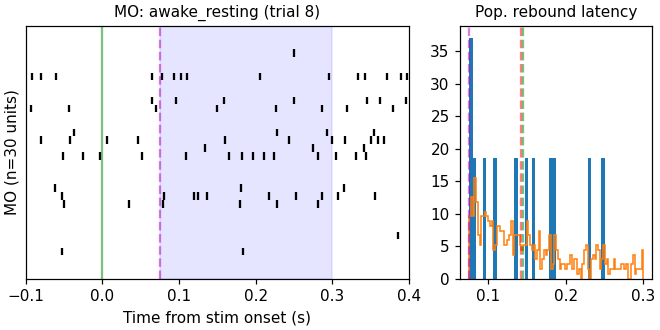

In [55]:
statei = 'awake_resting'
regi = 'MO'
triali = 8

raster_window = [-0.1, 0.4]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6,3), constrained_layout=True, gridspec_kw={'width_ratios': [2,1]})

axs[0].axvline(0, color='g', alpha=0.5)
axs[0].axvspan(late_window[0], late_window[1], color='b', alpha=0.1)
for indi, unit_event_spikes in enumerate(all_spike_info[statei][regi]['event_spikes']):
    axs[0].eventplot(unit_event_spikes[triali], lineoffsets=indi, linelengths=0.95, color='black')
axs[0].set_xlim(raster_window)
axs[0].set_xlabel('Time from stim onset (s)')
axs[0].set_yticks([])
axs[0].set_ylabel('{} (n={:d} units)'.format(regi, len(ROI_unit_info[regi])))
axs[0].set_title('{}: {} (trial {:d})'.format(regi, statei, triali))

axs[1].set_title('Pop. rebound latency')
tspiketimes = all_spike_info[statei][regi]['rebound_spike_times'][triali,:]
counts, spbins, pp = axs[1].hist(tspiketimes, bins=50, range=(late_window[0], late_window[1]), density=True)
axs[1].hist(
    all_spike_info[statei][regi]['rebound_spike_times'].flatten(),
    bins=100, range=(late_window[0], late_window[1]), histtype='step', density=True
)
axs[1].axvline(np.nanmedian(tspiketimes), color='r', linestyle='dashed', alpha=0.5)
axs[1].axvline(np.nanmean(tspiketimes), color='g', linestyle='dashed', alpha=0.5)
axs[1].axvline(spbins[np.argmax(counts)], color='m', linestyle='dashed', alpha=0.5)

axs[0].axvline(spbins[np.argmax(counts)], color='m', linestyle='dashed', alpha=0.5)

In [52]:
allc, allb = np.histogram(all_spike_info[statei][regi]['rebound_spike_times'], bins=100, range=(late_window[0], late_window[1]))
rebound_time_a = allb[np.argmax(allc)]
print(rebound_time_a)

0.09075


In [73]:
temp_rebound = []
for tspikes in all_spike_info[statei][regi]['rebound_spike_times']:
    tc, tb = np.histogram(tspikes, bins=100, range=(late_window[0], late_window[1]))
    if np.sum(tc) > 0:
        temp_rebound.append(tb[np.argmax(tc)])
print(len(temp_rebound))

30


In [74]:
print(np.mean(temp_rebound))
print(np.median(temp_rebound))
print(stats.mode(temp_rebound)[0][0])

0.09697499999999999
0.08512499999999999
0.07725


In [35]:
compare_states = ['awake_running', 'saline_running']
# plot_areas = ['MO', 'PL', 'ILA', 'ACA', 'RSP', 'SS', 'VIS', 'OLF', 'SM-TH', 'RT-TH', 'other-TH', 'HIP'] # 669117
# plot_areas = ['MO', 'PL', 'ORB', 'FRP', 'SS', 'OLF', 'SM-TH', 'other-TH', 'HIP'] # 669118
plot_areas = ['MO', 'ORB', 'FRP', 'STR', 'SS', 'VIS', 'OLF', 'HIP', 'SM-TH', 'RT-TH', 'other-TH'] # 666196
acolors = plt.cm.hsv(np.linspace(0, 1, len(plot_areas)))

Scatter plot of baseline firing rates in "compare_states"

<IPython.core.display.Javascript object>


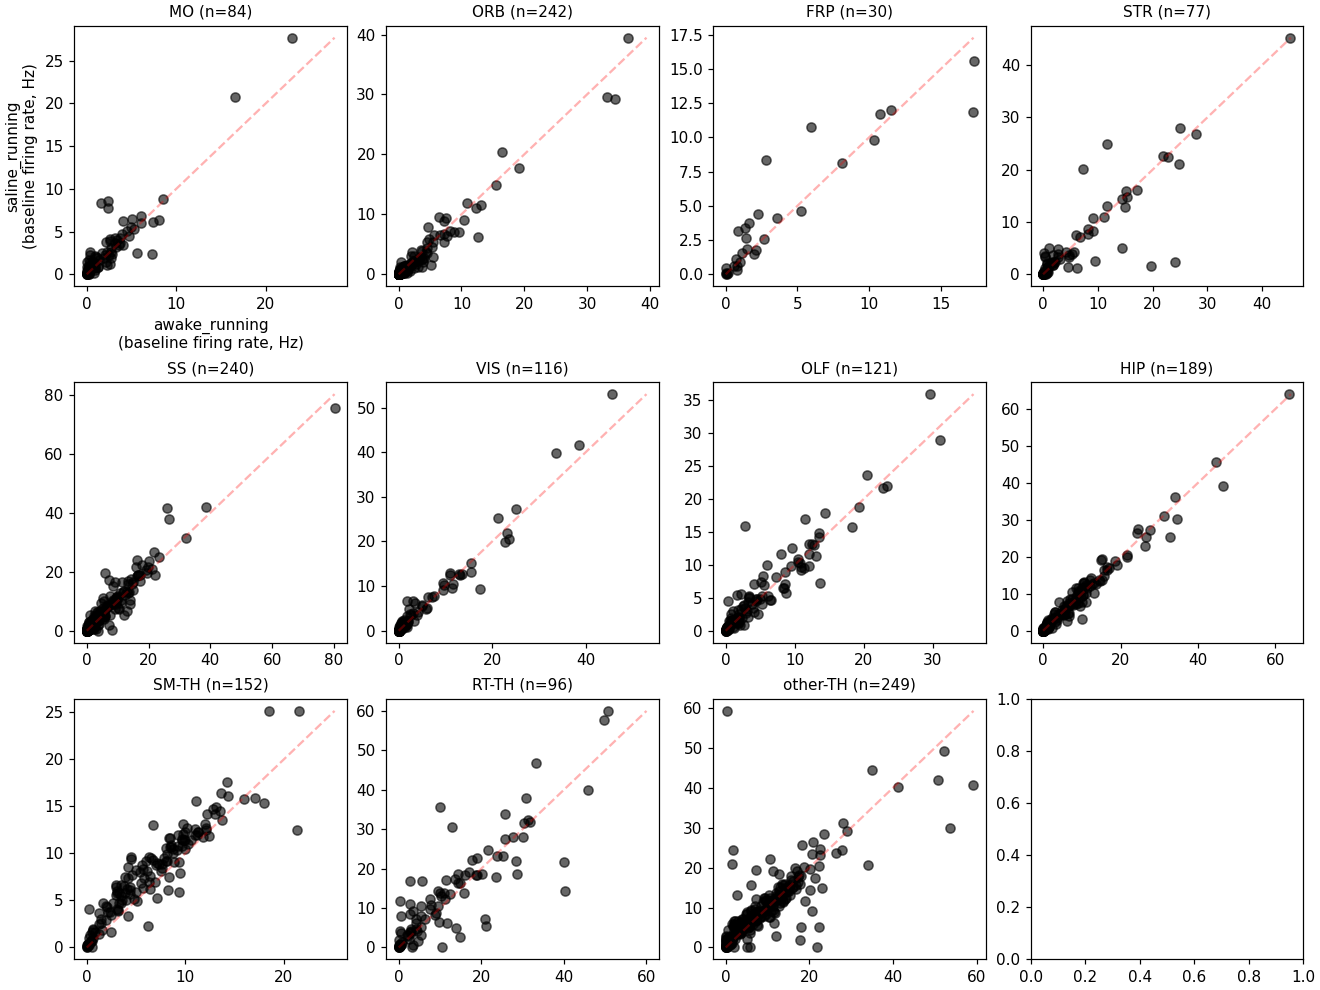

In [36]:
fig, axs = plt.subplots(3, 4, figsize=(12,9), constrained_layout=True)

for ax, regi in zip(axs.flatten(), plot_areas):
    scatter_vals = []
    for statei in compare_states:
        scatter_vals.append(all_data['unit_metrics'][statei][regi]['baselineFR'].values)
    min_val = np.min(scatter_vals)
    max_val = np.max(scatter_vals)
    ax.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='dashed', alpha=0.3)
    ax.scatter(scatter_vals[0], scatter_vals[1], color='k', alpha=0.6)
    ax.set_title('{} (n={:d})'.format(regi, len(scatter_vals[0])))

axs[0,0].set_xlabel('{}\n(baseline firing rate, Hz)'.format(compare_states[0]))
axs[0,0].set_ylabel('{}\n(baseline firing rate, Hz)'.format(compare_states[1]))

## Save ##
figname = '{}_{}_baselineFR_allregions.png'.format(subrow.mouse, subrow.exp_type)
fig.savefig(os.path.join(plotsdir, 'ind_sub_evoked_units', figname), transparent=False, dpi=300)

#### Plot one state

In [29]:
statei = 'awake_resting'

print(len(all_data['pop_fr'][statei]))

13


In [30]:
all_data['pop_fr']['awake_running'].keys()

dict_keys(['ACA', 'HIP', 'ILA', 'MO', 'OLF', 'PL', 'RHP', 'RSP', 'RT-TH', 'SM-TH', 'SS', 'VIS', 'other-TH'])

In [31]:
plot_areas = ['MO', 'PL', 'ILA', 'ACA', 'RSP', 'SS', 'VIS', 'OLF', 'SM-TH', 'RT-TH', 'other-TH', 'HIP', 'RHP']
print(len(plot_areas))
acolors = plt.cm.hsv(np.linspace(0, 1, len(plot_areas)))

13


<IPython.core.display.Javascript object>


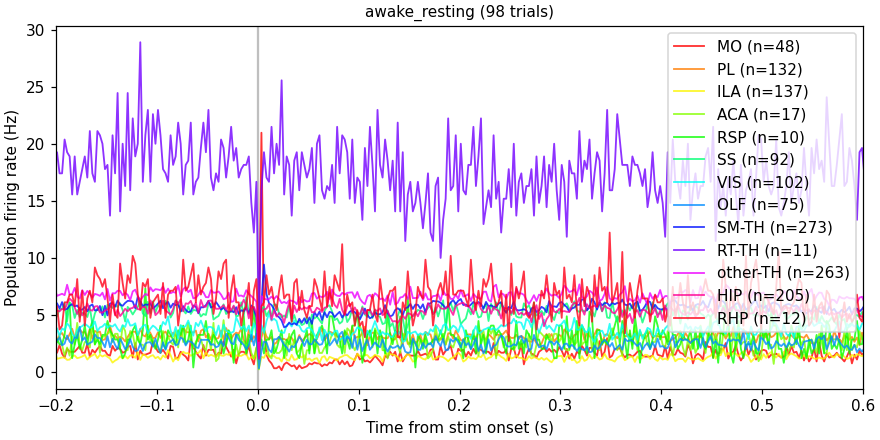

In [32]:
plot_window = [-0.2, 0.6]
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

ax.axvline(0, color='k', alpha=0.25)
for ii, regi in enumerate(plot_areas):
    timex = all_data['pop_fr'][statei][regi][0]
    traces = all_data['pop_fr'][statei][regi][1]
    num_units = len(all_data['unit_metrics'][statei][regi])
    ax.plot(timex, traces, color=acolors[ii], linewidth=1.2, alpha=0.8, label='{} (n={:d})'.format(regi, num_units))
    
ax.set_title('{} ({:d} trials)'.format(statei, all_data['trial_counts'][statei]))
ax.set_xlim(plot_window)
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Population firing rate (Hz)')
ax.legend(loc='upper right')

In [36]:
all_data['unit_metrics'][statei]['MO'].head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region,p_value,mean_spike_diff,early_latency,late_latency,burst_prob,burst_count,baselineFR
0,F546,probeF,339,280,0.796650,MOs2/3,123,73,177,MO,0.518348,-0.032,0.002960,0.237906,0.0,0.0,0.480
1,F528,probeF,318,480,0.618090,MOs5,125,81,180,MO,0.611167,-0.048,0.003366,0.234963,0.0,0.0,0.364
2,F527,probeF,317,500,0.755444,MOs5,125,81,181,MO,0.000144,-0.240,0.017943,0.264899,0.0,0.0,1.608
3,F520,probeF,314,520,0.260972,MOs5,125,82,181,MO,0.000979,-0.384,0.017178,0.220105,0.0,0.0,4.164
4,F506,probeF,300,660,0.700503,MOs5,126,88,184,MO,1.000000,0.000,NaN,NaN,0.0,0.0,0.000


In [37]:
## Find significantly activated neurons ##
region = 'MO'

sig_units = all_data['unit_metrics'][statei][region][
    (all_data['unit_metrics'][statei][region]['p_value'] < sigalpha) &
    (all_data['unit_metrics'][statei][region]['mean_spike_diff'] > 0) # looking for more spikes post than pre
]

print('{}: {:d}/{:d} units are sig. activated in rebound window'.format(
    region, len(sig_units), len(all_data['unit_metrics'][statei][region])
))

MO: 0/48 units are sig. activated in rebound window


In [38]:
sig_units.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region,p_value,mean_spike_diff,early_latency,late_latency,burst_prob,burst_count,baselineFR


##### Make some plots

In [20]:
Zlim = 5
plwin = [-0.2, 0.6]

fig = plt.figure(figsize=(len(unit_zscores)*2.4, 5))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 2.5], left=0.08, right=0.97, top=0.9, bottom=0.1, hspace=0.1)
popaxs = gs[0].subgridspec(ncols=len(unit_zscores), nrows=1, wspace=0.14).subplots(sharex=True, sharey=True)
Zaxs = gs[1].subgridspec(ncols=len(unit_zscores), nrows=len(ROI_unit_info), hspace=0.08, wspace=0.14).subplots(sharex=True)

for jj, (statei, statedict) in enumerate(unit_zscores.items()):
    popaxs[jj].axvline(0, color='k', alpha=0.25)
    for ii, (regi, datai) in enumerate(statedict.items()):
        popaxs[jj].plot(
            pop_firing_rates[statei][regi][0], pop_firing_rates[statei][regi][1],
            color=areacolors[regi], linewidth=1.2, alpha=0.8, label=regi
        )
        imunit = Zaxs[ii,jj].imshow(
            datai[1].T, cmap='bwr', interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[datai[0][0], datai[0][-1], 0, datai[1].shape[0]],
        )
        Zaxs[ii,jj].axvline(0, color='k', alpha=0.25)
        Zaxs[ii,jj].set_ylabel('{} (n={:d})'.format(regi, datai[1].shape[1]))
        Zaxs[ii,jj].set_yticks([])

    Zaxs[ii,jj].set_xlim(plwin)
    Zaxs[ii,jj].set_xlabel('Time from stim onset (s)')

    popaxs[jj].set_xlim(plwin)
    popaxs[jj].set_xticklabels([])
    popaxs[jj].set_title('{} ({:d} trials)'.format(statei, len(state_event_inds[statei])))
popaxs[0].set_ylabel('Pop. FR (Hz)')
popaxs[0].legend()

NameError: name 'unit_zscores' is not defined

<IPython.core.display.Javascript object>


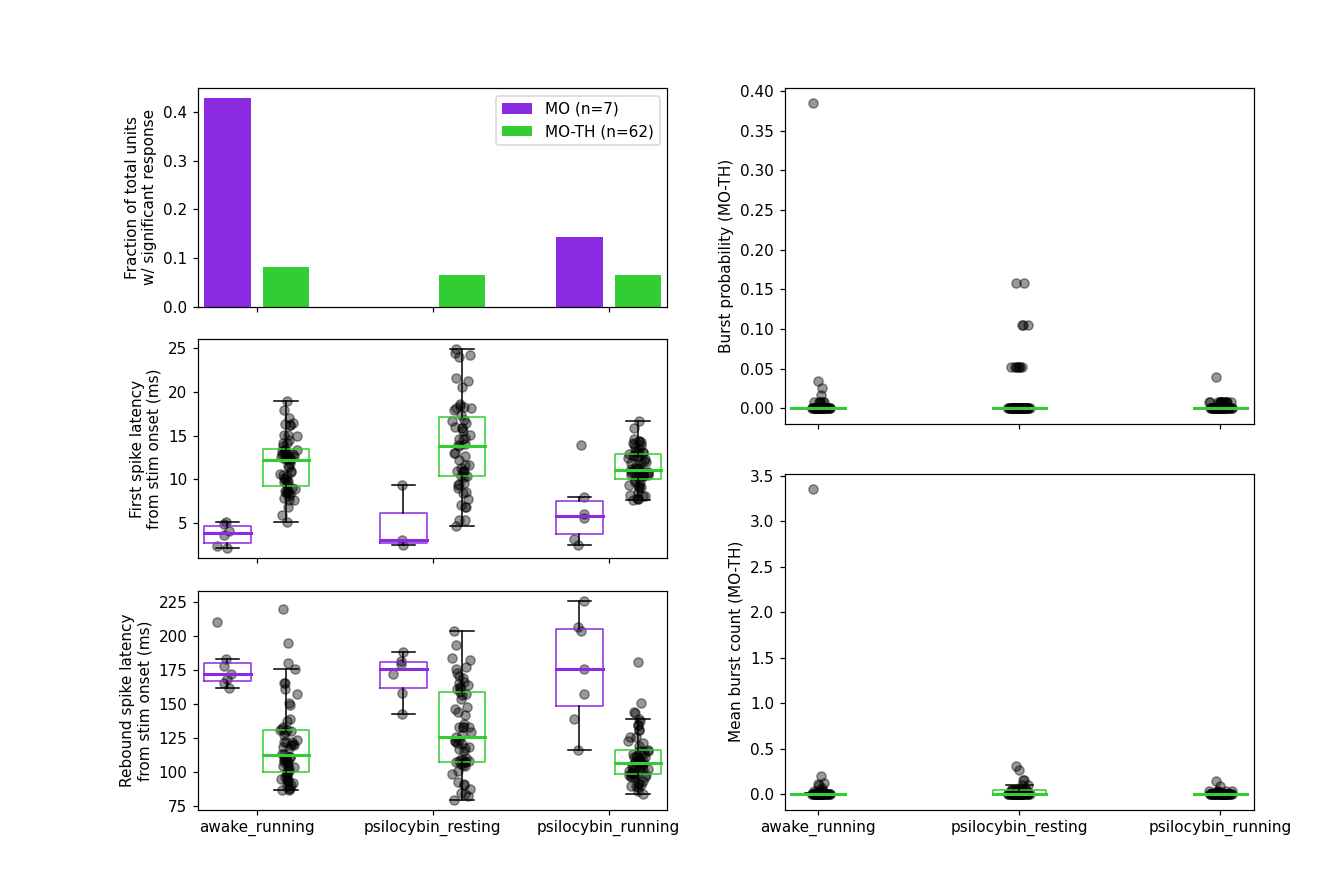

[Text(1, 0, 'awake_running'),
 Text(4, 0, 'psilocybin_resting'),
 Text(7, 0, 'psilocybin_running')]

In [28]:
locs = np.arange((len(ROI_unit_info) + 1) * len(unit_metrics)).reshape((len(unit_metrics), (len(ROI_unit_info) + 1)))
burst_region = 'MO-TH'

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(ncols=2, nrows=1, left=0.15, right=0.95, top=0.9, bottom=0.08, wspace=0.25)
axs = gs[0].subgridspec(ncols=1, nrows=3, hspace=0.15).subplots(sharex=True)
bxs = gs[1].subgridspec(ncols=1, nrows=2, hspace=0.15).subplots(sharex=True)

for ii, (statei, statemets) in enumerate(unit_metrics.items()):
    for jj, (regi, reg_metrics) in enumerate(statemets.items()):
        total_units = len(reg_metrics)
        xs = np.random.normal(locs[ii,jj], 0.08, total_units)
        ## Fraction of total units that are significantly activated (excited+inhibited) ##
        sig_units = np.sum(reg_metrics['p_value'].values < sigalpha)
        axs[0].bar(locs[ii,jj], sig_units/total_units, color=areacolors[regi])
        
        ## Early spike latency ##
        early_lats = reg_metrics['early_latency'].values * 1E3
        axs[1].scatter(xs, early_lats, color='k', marker='o', alpha=0.4)
        axs[1].boxplot(
            early_lats[~np.isnan(early_lats)], positions=[locs[ii,jj]], widths=[0.8], showfliers=False, 
            medianprops={'color': areacolors[regi], 'linewidth': 2}, boxprops={'color': areacolors[regi]},
        )
        
        ## Late spike latency ##
        late_lats = reg_metrics['late_latency'].values * 1E3
        axs[2].scatter(xs, late_lats, color='k', marker='o', alpha=0.4)
        axs[2].boxplot(
            late_lats[~np.isnan(late_lats)], positions=[locs[ii,jj]], widths=[0.8], showfliers=False, 
            medianprops={'color': areacolors[regi], 'linewidth': 2}, boxprops={'color': areacolors[regi]},
        )
        
        if regi == burst_region:
            ## Burst probability ##
            bxs[0].scatter(xs, reg_metrics['burst_prob'].values, color='k', marker='o', alpha=0.4)
            bxs[0].boxplot(
                reg_metrics['burst_prob'].values, positions=[locs[ii,jj]], widths=[0.8], showfliers=False, 
                medianprops={'color': areacolors[regi], 'linewidth': 2}, boxprops={'color': areacolors[regi]},
            )
            
            ## Burst count ##
            bxs[1].scatter(xs, reg_metrics['burst_count'].values, color='k', marker='o', alpha=0.4)
            bxs[1].boxplot(
                reg_metrics['burst_count'].values, positions=[locs[ii,jj]], widths=[0.8], showfliers=False, 
                medianprops={'color': areacolors[regi], 'linewidth': 2}, boxprops={'color': areacolors[regi]},
            )
            
        
axs[0].set_ylabel('Fraction of total units\nw/ significant response')
axs[1].set_ylabel('First spike latency\nfrom stim onset (ms)')
axs[2].set_ylabel('Rebound spike latency\nfrom stim onset (ms)')
axs[2].set_xticks(np.mean(locs[:,:-1], axis=1))
axs[2].set_xticklabels(unit_metrics.keys())

regleg = []
for regi, reg_metrics in statemets.items():
    regleg.append(Patch(facecolor=areacolors[regi], label='{} (n={:d})'.format(regi, len(reg_metrics))))
axs[0].legend(handles=regleg)

bxs[0].set_ylabel('Burst probability ({})'.format(burst_region))
bxs[1].set_ylabel('Mean burst count ({})'.format(burst_region))
bxs[1].set_xticks(locs[:,1])
bxs[1].set_xticklabels(unit_metrics.keys())